# P4 - Anticipez le retard de vol des avions

## Récupération des données

In [1]:
import pandas as pd
import numpy as np
import time
import os

# Option pour ne pas tout charger
ALLFILES = True
# Mon répertoire de données en local
CT_DIR_DATA = 'C:\Work\OpenClassrooms\data\P4/'

filename = '2016_'
# Récupération du 1er fichier
dataraw = pd.read_csv(CT_DIR_DATA + filename + '01_ready.csv', sep="\t", encoding='utf-8')
print(dataraw.shape)
print(dataraw.columns)

if ALLFILES:
    # Concaténation de toutes les données
    for i in range(2, 13):
        n = CT_DIR_DATA + filename + '%0*d' % (2, i) + '_ready.csv'
        print('reading', n, '...')
        f = pd.read_csv(n, sep="\t", encoding='utf-8')
        print('shape ', f.shape)
        dataraw = dataraw.append(f, ignore_index=True)
        dataraw.index = range(len(dataraw.index))
print(dataraw.shape)


(433298, 9)
Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'ARR_DELAY', 'DEP_HOUR',
       'HDAYS'],
      dtype='object')
reading C:\Work\OpenClassrooms\data\P4/2016_02_ready.csv ...
shape  (416097, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_03_ready.csv ...
shape  (473286, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_04_ready.csv ...
shape  (474752, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_05_ready.csv ...
shape  (475499, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_06_ready.csv ...
shape  (480916, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_07_ready.csv ...
shape  (491198, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_08_ready.csv ...
shape  (489965, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_09_ready.csv ...
shape  (452558, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_10_ready.csv ...
shape  (467486, 9)
reading C:\Work\OpenClassrooms\data\P4/2016_11_ready.csv ...
shape  (448911, 9)
reading C:\

In [2]:
# Méthodes d'import export
import pickle
from sklearn.externals import joblib
CT_DIR = '../flightdelay/save/'

def save_obj(obj, name):
    fn = CT_DIR + name + '.pkl'
    try:
        os.remove(fn)
    except OSError:
        pass
    with open(fn, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print(fn, 'saved')

def load_obj(name):
    with open(CT_DIR + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_sklearn_obj(obj, name):
    fn = CT_DIR + name + '.pkl'
    try:
        os.remove(fn)
    except OSError:
        pass
    joblib.dump(obj, fn)
    print(fn, 'saved')

def load_sklearn_obj(name):
    return joblib.load(CT_DIR + name + '.pkl')

## Préparation au calcul

In [3]:
dataraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556195 entries, 0 to 5556194
Data columns (total 9 columns):
MONTH                int64
DAY_OF_MONTH         int64
DAY_OF_WEEK          int64
UNIQUE_CARRIER       object
ORIGIN_AIRPORT_ID    int64
ORIGIN_CITY_NAME     object
ARR_DELAY            float64
DEP_HOUR             int64
HDAYS                int64
dtypes: float64(1), int64(6), object(2)
memory usage: 381.5+ MB


Préparation des données pour la recherche d'un modèle : 
    
    Binarisation

    Scaling
    
    Jeu de training, jeu de test

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def PrepareData(p_df, c, bSave=False):

    # On fait un choix de colonnes restreint en pensant à ce que l'utilisateur pourra renseigner dans la page web
    # Les numériques
    scalingDF = p_df[['HDAYS']].astype('float')
    # Les catégories
    categDF = p_df[['MONTH', 'ORIGIN_AIRPORT_ID', 'DEP_HOUR', 'DAY_OF_WEEK']]
    
    y_final = p_df['ARR_DELAY'].values
    y_final.mean()        
    
    # Binarisation en dummies pour garder la maitrise des noms des colonnes
    categDF_encoded = pd.get_dummies(categDF.astype(np.str))

    # Concaténation
    x_final = pd.concat([scalingDF, categDF_encoded], axis=1)

    if bSave:
        # Sauvegarde de la liste des colonnes pour le web
        x_save = x_final[x_final.HDAYS==-1]
        save_obj(x_save, 'model_columns_'+c)

    x_train, x_test, y_train, y_test = train_test_split(x_final,y_final,test_size = 0.2,random_state = 0)

    # Seules les xnum premières colonnes sont numériques
    xnum = scalingDF.shape[1]
    x_train_numerical = x_train.iloc[:, 0:xnum]
    x_test_numerical = x_test.iloc[:, 0:xnum]

    # Création d'un scaler pour les valeurs numériques 
    scaler = StandardScaler()
    # Qu'on entraine avec le training set
    scaler.fit(x_train_numerical) 

    if bSave:
        # Sauvegarde pour le web
        save_sklearn_obj(scaler, 'model_scaler_'+c)
    
    x_train_numerical = scaler.transform(x_train_numerical)
    x_test_numerical = scaler.transform(x_test_numerical)

    x_train = x_train.copy()
    x_test = x_test.copy()
    x_train.loc[:, 0:xnum] = x_train_numerical
    x_test.loc[:, 0:xnum] = x_test_numerical

    return x_train, x_test, y_train, y_test


## Recherche d'un modèle

On commence par un DummyRegressor, modèle naïf pour avoir un ordre de grandeur des scores et de la valeur à améliorer

Ensuite on boucle sur des modèles de régression de plus en plus hyperparamétrables

Pour cela on utilise un GridSearch avec validation croisée

On regarde la MAE pour avoir des minutes en unité

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor, Lars, SGDRegressor
from sklearn.dummy import DummyRegressor

def CompareModel(p_df, c):
    # Récupération des données préparées
    x_train, x_test, y_train, y_test = PrepareData(p_df, c)

    modeles = [
        # Dummy comme base de référence
        (DummyRegressor(strategy='mean'), {}),
        # Régression simple pour commencer
        (LinearRegression(), {}),
        # LARS (Pas forcément adapté car meilleur avec plus de features que de points et sensible aux outliers mais pour voir)
        (Lars(), {}),
        # Ridge (régulation de Tykhonov, norme l2)
        (Ridge(), {'alpha':[0.01, 0.1, 1]}),
        # Coefficient de régularisation de norme l1
        (Lasso(), {'alpha':[0.01, 0.1, 1]}),
        # Combinaison de Ridge et LASSO
        (ElasticNet(), {'alpha':[0.01, 0.1, 1], 'l1_ratio':[0.1, 0.5, 0.9]}),
        # Descente de gradient stochastique, optimisation de l'approximation à chaque itération, adapdé aux grandes dimensions
        # On va pouvoir traiter les outliers de différentes façons
        (SGDRegressor(), {'loss':['squared_loss', 'huber', 'epsilon_insensitive'], 'max_iter':[1000]}),
#        (SGDRegressor(loss='epsilon_insensitive'), {'penalty':['l1', 'l2', 'elasticnet'], 'max_iter':[1000]}),
#        (SGDRegressor(loss='epsilon_insensitive'), {'l1_ratio':[0.1, 0.15, 0.2], 'max_iter':[1000]}),
#        (SGDRegressor(loss='epsilon_insensitive'), {'alpha':10.0**-np.arange(4,7), 'max_iter':[1000]}),
        # Bonne gestion des outliers
        (HuberRegressor(), {'alpha':[0.0001, 0.001, 0.01, 1], 'epsilon':[1, 1.35]}),
    ]
    
    for mod, params in modeles:
        # On entraine le modèle sur différents paramètres et en validation croisée
        gs = GridSearchCV(mod, params, scoring = 'neg_mean_absolute_error', cv=5, refit=True)
        gs.fit(x_train, y_train)
        print("MAE = %.3f" % mean_absolute_error(y_test, gs.best_estimator_.predict(x_test)))
        print("\tbest_estimator_=", gs.best_estimator_)

    return


In [55]:
lst_carriers = list(sorted(set(dataraw['UNIQUE_CARRIER'])))
for c in lst_carriers:
    df = dataraw[dataraw.UNIQUE_CARRIER == c]
    df = df[df.MONTH == 1]
    print(df.shape)
    CompareModel(df, c)
    break

(72736, 9)
MAE = 19.930
	best_estimator_= DummyRegressor(constant=None, quantile=None, strategy='mean')
MAE = 7409559.192
	best_estimator_= LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
MAE = 19.701
	best_estimator_= Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)
MAE = 19.699
	best_estimator_= Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
MAE = 19.647
	best_estimator_= Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
MAE = 19.629
	best_estimator_= ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None

Les différents tests montrent que la régression linéaire de base est très sensible aux outliers.
En effet le score devient extrêment mauvais si on teste avec des échantillons qui contiennent quelques outliers un peu gros.

La régularisation permet de palier à ce problème mais reste quand même bien influencée.

On observe une bonne amélioration du modèle lorsque l'on traite les outliers différemment, en considérant la perte comme linéaire plutôt que quadratique passé un certain palier (méthode de perte de Huber).

C'est même encore mieux avec la méthode epsilon_insensitive qui ignore les erreurs inférieur au palier epsilon, en tout cas avec une descente de gradient stochastique.

In [60]:
# On le refait avec l'ensembles des données de la première compagnie
lst_carriers = list(sorted(set(dataraw['UNIQUE_CARRIER'])))
for c in lst_carriers:
    df = dataraw[dataraw.UNIQUE_CARRIER == c]
    print(df.shape)
    CompareModel(df, c)
    break

(873209, 9)
MAE = 22.675
	best_estimator_= DummyRegressor(constant=None, quantile=None, strategy='mean')
MAE = 22.190
	best_estimator_= LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
MAE = 22.190
	best_estimator_= Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)
MAE = 22.190
	best_estimator_= Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
MAE = 22.171
	best_estimator_= Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
MAE = 22.142
	best_estimator_= ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, sel

## GO

In [59]:
for c in lst_carriers:
    print(c)
    df = dataraw[dataraw.UNIQUE_CARRIER == c]
    print (df.shape)
#    df.to_csv(CT_DIR_DATA + '2016_' + c + '.csv', sep="\t", encoding='utf-8', index=False)
    
    model = HuberRegressor(alpha=1, epsilon=1)
    gs = GridSearchCV(model, {}, scoring = 'neg_mean_absolute_error', cv = 5)

    x_train, x_test, y_train, y_test = PrepareData(df, c, True)
    gs.fit(x_train, y_train)

    mae = mean_absolute_error(y_test, gs.predict(x_test))
    print ('MAE = %.3f' % mae)
    save_sklearn_obj(gs, 'model_Huber_'+c)


AA
(873209, 9)
../flightdelay/save/model_columns_AA.pkl saved
../flightdelay/save/model_scaler_AA.pkl saved
MAE = 19.989
../flightdelay/save/model_Huber_AA.pkl saved
AS
(165641, 9)
../flightdelay/save/model_columns_AS.pkl saved
../flightdelay/save/model_scaler_AS.pkl saved
MAE = 14.366
../flightdelay/save/model_Huber_AS.pkl saved
B6
(280251, 9)
../flightdelay/save/model_columns_B6.pkl saved
../flightdelay/save/model_scaler_B6.pkl saved
MAE = 23.572
../flightdelay/save/model_Huber_B6.pkl saved
DL
(964797, 9)
../flightdelay/save/model_columns_DL.pkl saved
../flightdelay/save/model_scaler_DL.pkl saved
MAE = 17.267
../flightdelay/save/model_Huber_DL.pkl saved
EV
(489510, 9)
../flightdelay/save/model_columns_EV.pkl saved
../flightdelay/save/model_scaler_EV.pkl saved
MAE = 21.295
../flightdelay/save/model_Huber_EV.pkl saved
F9
(94505, 9)
../flightdelay/save/model_columns_F9.pkl saved
../flightdelay/save/model_scaler_F9.pkl saved
MAE = 25.037
../flightdelay/save/model_Huber_F9.pkl saved
HA
(7

## Analyse des coefficients alpha

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df = dataraw[dataraw.MONTH == 1]
df = df[df.UNIQUE_CARRIER == 'AA']
x_train, x_test, y_train, y_test = PrepareData(df, 'AA')
alphas = 10.0**-np.arange(-4,6)
coefs1 = []
coefs2 = []
coefs3 = []
coefs4 = []
coefs5 = []
for a in alphas:
    mod = Ridge(alpha=a)
    mod.fit(x_train, y_train)
    coefs1.append(mean_absolute_error(y_test, mod.predict(x_test)))

    mod = Lasso(alpha=a)
    mod.fit(x_train, y_train)
    coefs2.append(mean_absolute_error(y_test, mod.predict(x_test)))
    
    mod = ElasticNet(alpha=a)
    mod.fit(x_train, y_train)
    coefs3.append(mean_absolute_error(y_test, mod.predict(x_test)))
    
    mod = SGDRegressor(alpha=a, max_iter=1000)
    mod.fit(x_train, y_train)
    coefs4.append(mean_absolute_error(y_test, mod.predict(x_test)))
        
    mod = HuberRegressor(alpha=a)
    mod.fit(x_train, y_train)
    coefs5.append(mean_absolute_error(y_test, mod.predict(x_test)))
alphas

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([  1.00000000e+04,   1.00000000e+03,   1.00000000e+02,
         1.00000000e+01,   1.00000000e+00,   1.00000000e-01,
         1.00000000e-02,   1.00000000e-03,   1.00000000e-04,
         1.00000000e-05])

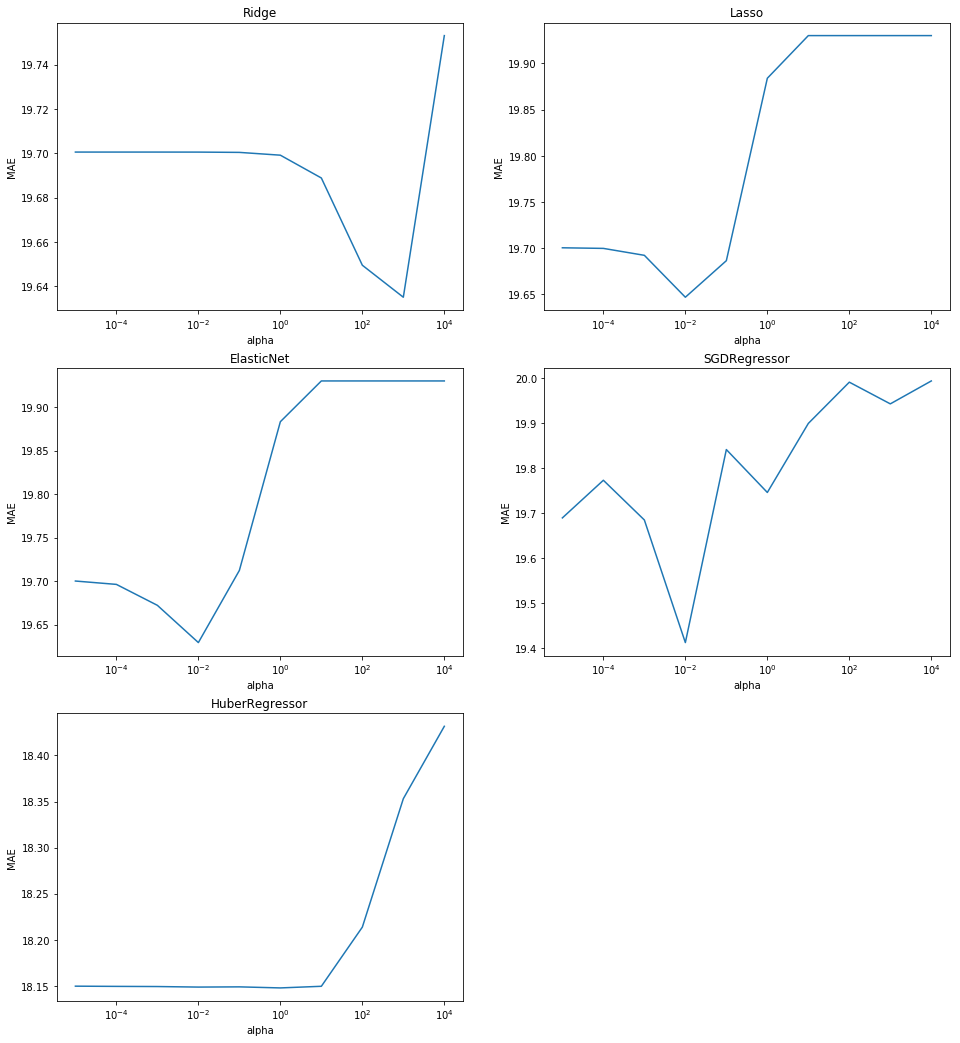

In [10]:
fig = plt.figure(figsize=(16, 18))
plt.subplot(3, 2, 1)
ax = plt.gca()
ax.plot(alphas, coefs1)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('Ridge')

plt.subplot(3, 2, 2)
ax = plt.gca()
ax.plot(alphas, coefs2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('Lasso')

plt.subplot(3, 2, 3)
ax = plt.gca()
ax.plot(alphas, coefs3)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('ElasticNet')

plt.subplot(3, 2, 4)
ax = plt.gca()
ax.plot(alphas, coefs4)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('SGDRegressor')

plt.subplot(3, 2, 5)
ax = plt.gca()
ax.plot(alphas, coefs5)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('HuberRegressor')
plt.show()

Les meilleurs résultats sont avec alpha <= 0 pour tous les modèles sauf Ridge (best alpha = 1000 environ)

Mais le meilleur modèle reste HuberRegressor avec alpha=0

## Analyse du l1 ratio

In [11]:
ratios = np.arange(0.0, 1.1, 0.1)
coefsR1 = []
coefsR2 = []
for r in ratios:
    mod = ElasticNet(l1_ratio=r)
    mod.fit(x_train, y_train)
    coefsR1.append(mean_absolute_error(y_test, mod.predict(x_test)))

    mod = SGDRegressor(alpha=a, max_iter=1000)
    mod.fit(x_train, y_train)
    coefsR2.append(mean_absolute_error(y_test, mod.predict(x_test)))
ratios

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

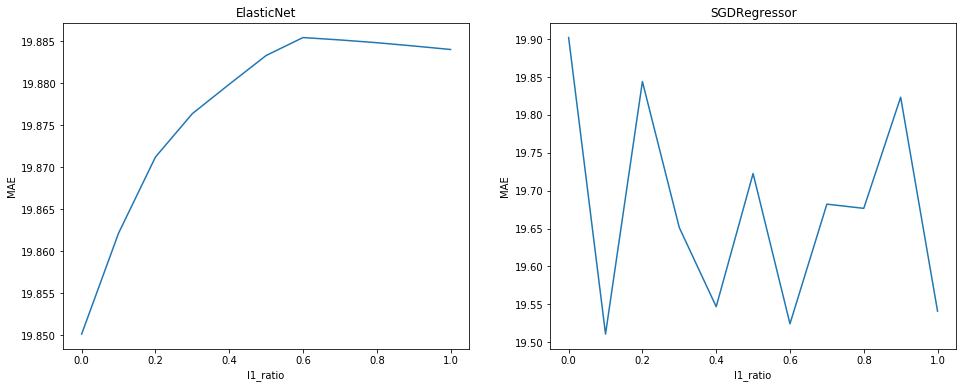

In [12]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.plot(ratios, coefsR1)
plt.xlabel('l1_ratio')
plt.ylabel('MAE')
plt.title('ElasticNet')

plt.subplot(1, 2, 2)
ax = plt.gca()
ax.plot(ratios, coefsR2)
plt.xlabel('l1_ratio')
plt.ylabel('MAE')
plt.title('SGDRegressor')

plt.show()

Une pénalité de type l2 (pour l1_ratio=0) donne une meilleure MAE avec ElasticNet

## Gestion des outliers

In [13]:
dfOutliers = dataraw.copy()

q75, q25 = np.percentile(dfOutliers.ARR_DELAY, [75 ,25])
iqr = q75 - q25
nmin = q25 - (iqr*1.5)
nmax = q75 + (iqr*1.5)
print(nmin)
print(nmax)

-44.0
36.0


In [35]:
# En fait seuls les retards nous intéresse donc on se débarasse des vols en avance
dfOutliers = dfOutliers[dfOutliers.ARR_DELAY > 0]
dfOutliers.loc[dfOutliers.ARR_DELAY>40, 'ARR_DELAY'] = 40
dfOutliers.shape

(1890512, 9)

In [36]:
lst_carriers = list(sorted(set(dataraw['UNIQUE_CARRIER'])))
for c in lst_carriers:
    df = dfOutliers[dfOutliers.UNIQUE_CARRIER == c]
    df = df[df.MONTH == 1]
    print(df.shape)
    CompareModel(df, c)
    break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(25215, 9)
MAE = 12.496
	best_estimator_= DummyRegressor(constant=None, quantile=None, strategy='mean')
MAE = 12.275
	best_estimator_= LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
MAE = 12.275
	best_estimator_= Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)
MAE = 12.274
	best_estimator_= Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
MAE = 12.270
	best_estimator_= Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
MAE = 12.273
	best_estimator_= ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, sel

Il faut borner les outliers, les résultats sont bien meilleurs

## Analyse des coefficients alpha sans les outliers

In [37]:
df = dfOutliers[dataraw.MONTH == 1]
df = df[df.UNIQUE_CARRIER == 'AA']
x_train, x_test, y_train, y_test = PrepareData(df, 'AA')
alphas = 10.0**-np.arange(-4,6)
coefs1 = []
coefs2 = []
coefs3 = []
coefs4 = []
coefs5 = []
for a in alphas:
    mod = Ridge(alpha=a)
    mod.fit(x_train, y_train)
    coefs1.append(mean_absolute_error(y_test, mod.predict(x_test)))

    mod = Lasso(alpha=a)
    mod.fit(x_train, y_train)
    coefs2.append(mean_absolute_error(y_test, mod.predict(x_test)))
    
    mod = ElasticNet(alpha=a)
    mod.fit(x_train, y_train)
    coefs3.append(mean_absolute_error(y_test, mod.predict(x_test)))
    
    mod = SGDRegressor(alpha=a, max_iter=1000)
    mod.fit(x_train, y_train)
    coefs4.append(mean_absolute_error(y_test, mod.predict(x_test)))
        
    mod = HuberRegressor(alpha=a)
    mod.fit(x_train, y_train)
    coefs5.append(mean_absolute_error(y_test, mod.predict(x_test)))
alphas

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([  1.00000000e+04,   1.00000000e+03,   1.00000000e+02,
         1.00000000e+01,   1.00000000e+00,   1.00000000e-01,
         1.00000000e-02,   1.00000000e-03,   1.00000000e-04,
         1.00000000e-05])

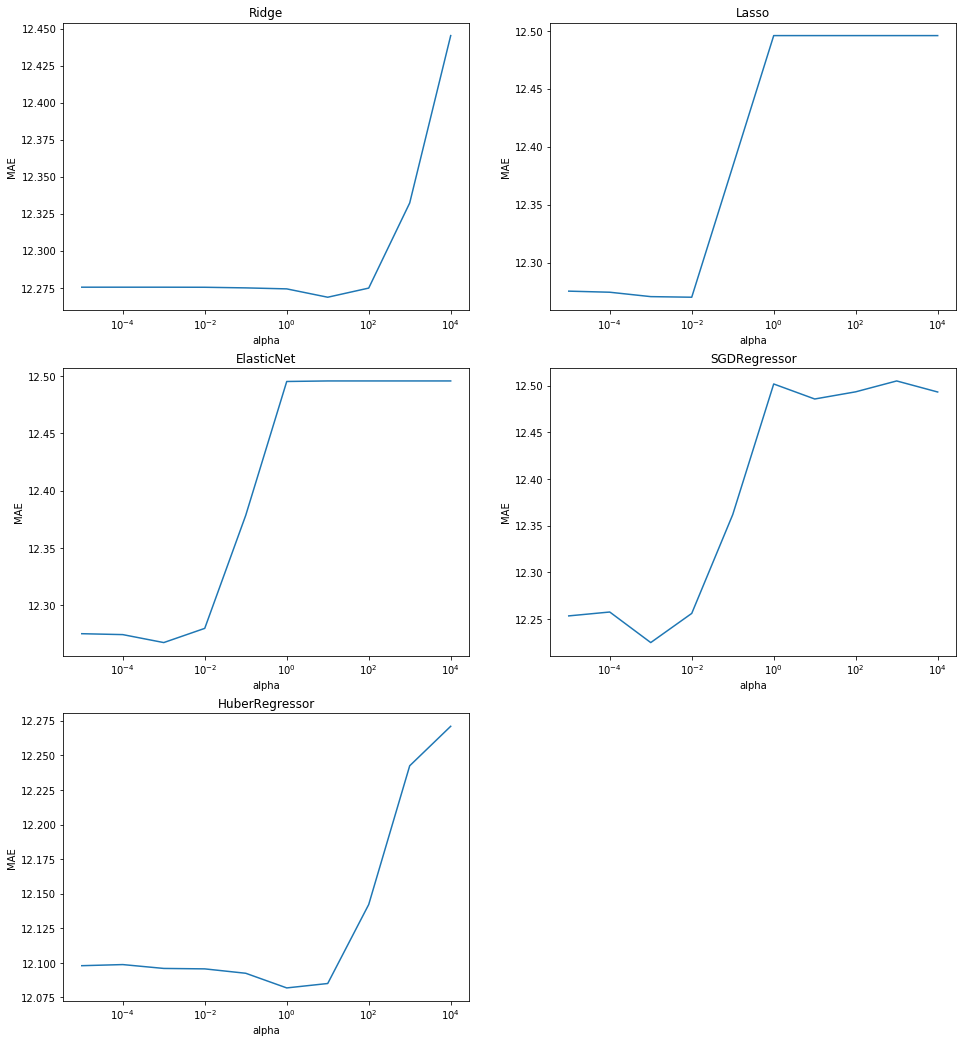

In [38]:
fig = plt.figure(figsize=(16, 18))
plt.subplot(3, 2, 1)
ax = plt.gca()
ax.plot(alphas, coefs1)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('Ridge')

plt.subplot(3, 2, 2)
ax = plt.gca()
ax.plot(alphas, coefs2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('Lasso')

plt.subplot(3, 2, 3)
ax = plt.gca()
ax.plot(alphas, coefs3)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('ElasticNet')

plt.subplot(3, 2, 4)
ax = plt.gca()
ax.plot(alphas, coefs4)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('SGDRegressor')

plt.subplot(3, 2, 5)
ax = plt.gca()
ax.plot(alphas, coefs5)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('HuberRegressor')
plt.show()

## Analyse du l1 ratio sans les outliers

In [39]:
ratios = np.arange(0.0, 1.1, 0.1)
coefsR1 = []
coefsR2 = []
for r in ratios:
    mod = ElasticNet(l1_ratio=r)
    mod.fit(x_train, y_train)
    coefsR1.append(mean_absolute_error(y_test, mod.predict(x_test)))

    mod = SGDRegressor(alpha=a, max_iter=1000)
    mod.fit(x_train, y_train)
    coefsR2.append(mean_absolute_error(y_test, mod.predict(x_test)))
ratios

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

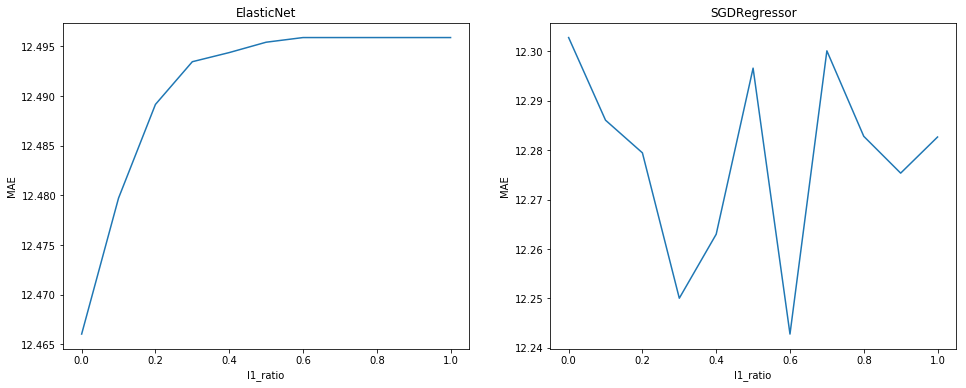

In [40]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.plot(ratios, coefsR1)
plt.xlabel('l1_ratio')
plt.ylabel('MAE')
plt.title('ElasticNet')

plt.subplot(1, 2, 2)
ax = plt.gca()
ax.plot(ratios, coefsR2)
plt.xlabel('l1_ratio')
plt.ylabel('MAE')
plt.title('SGDRegressor')

plt.show()

## GO pour le modèle final

In [47]:
for c in lst_carriers:
    print(c)
    df = dfOutliers[dfOutliers.UNIQUE_CARRIER == c]
    print (df.shape)
    
    model = SGDRegressor(alpha=0.0001, l1_ratio=1, penalty='l2', loss='epsilon_insensitive', max_iter=1000)
    gs = GridSearchCV(model, {}, scoring = 'neg_mean_absolute_error', cv = 5)

    x_train, x_test, y_train, y_test = PrepareData(df, c, True)
    gs.fit(x_train, y_train)

    mae = mean_absolute_error(y_test, gs.predict(x_test))
    print ('MAE = %.3f' % mae)
    save_sklearn_obj(gs, 'model_SGD_'+c)


AA
(327418, 9)
../flightdelay/save/model_columns_AA.pkl saved
../flightdelay/save/model_scaler_AA.pkl saved
MAE = 12.436
../flightdelay/save/model_SGD_AA.pkl saved
AS
(52122, 9)
../flightdelay/save/model_columns_AS.pkl saved
../flightdelay/save/model_scaler_AS.pkl saved
MAE = 10.248
../flightdelay/save/model_SGD_AS.pkl saved
B6
(112362, 9)
../flightdelay/save/model_columns_B6.pkl saved
../flightdelay/save/model_scaler_B6.pkl saved
MAE = 12.784
../flightdelay/save/model_SGD_B6.pkl saved
DL
(250170, 9)
../flightdelay/save/model_columns_DL.pkl saved
../flightdelay/save/model_scaler_DL.pkl saved
MAE = 12.313
../flightdelay/save/model_SGD_DL.pkl saved
EV
(161405, 9)
../flightdelay/save/model_columns_EV.pkl saved
../flightdelay/save/model_scaler_EV.pkl saved
MAE = 13.194
../flightdelay/save/model_SGD_EV.pkl saved
F9
(35775, 9)
../flightdelay/save/model_columns_F9.pkl saved
../flightdelay/save/model_scaler_F9.pkl saved
MAE = 13.216
../flightdelay/save/model_SGD_F9.pkl saved
HA
(25645, 9)
../f

## Valeurs résiduelles

In [48]:
df = dfOutliers[dfOutliers.UNIQUE_CARRIER == 'AA'].sample(10000)
print (df.shape)
x_train, x_test, y_train, y_test = PrepareData(df, c)

model = SGDRegressor(alpha=0.0001, l1_ratio=1, penalty='l2', loss='epsilon_insensitive', max_iter=1000)
gs = GridSearchCV(model, {}, scoring = 'neg_mean_absolute_error', cv = 5)
gs.fit(x_train, y_train)

y_pred = gs.predict(x_test)

(10000, 9)


Text(0.5,1,'Retards prédits vs réels sans les outliers')

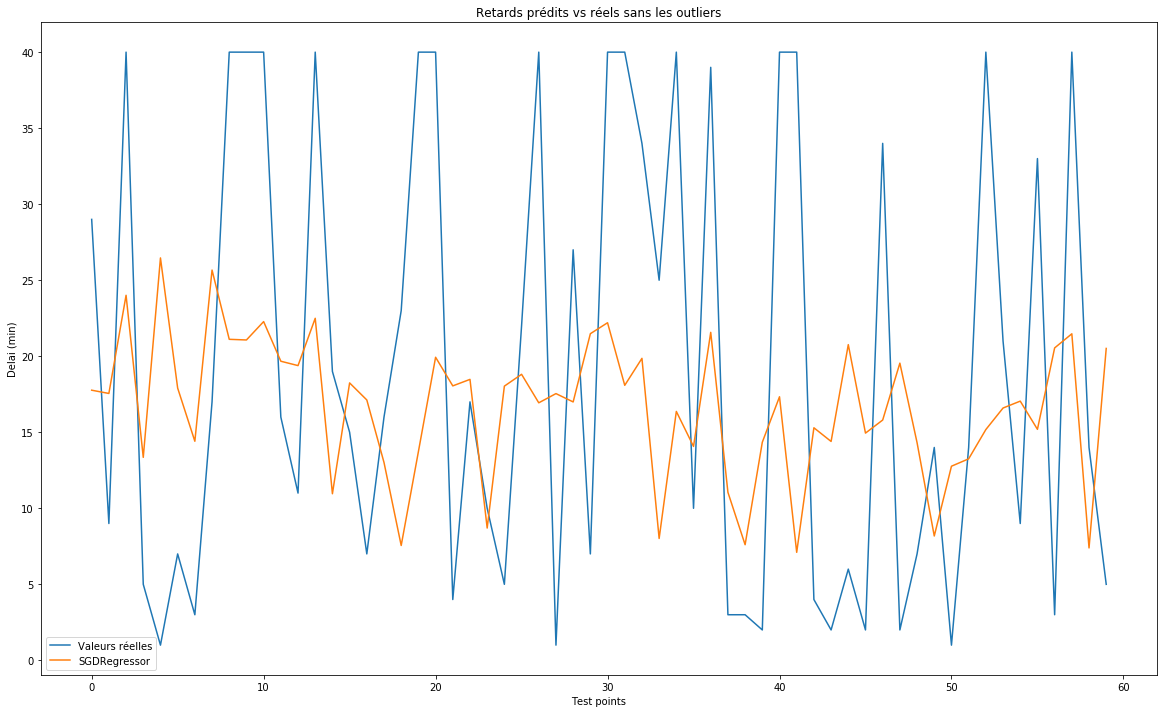

In [58]:
start = 0
width = 60
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Valeurs réelles")
plt.plot(range(width), y_pred[start:start+width], label="SGDRegressor")

plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits vs réels sans les outliers")

Text(0.5,1,'Valeur résiduelles sans les outliers')

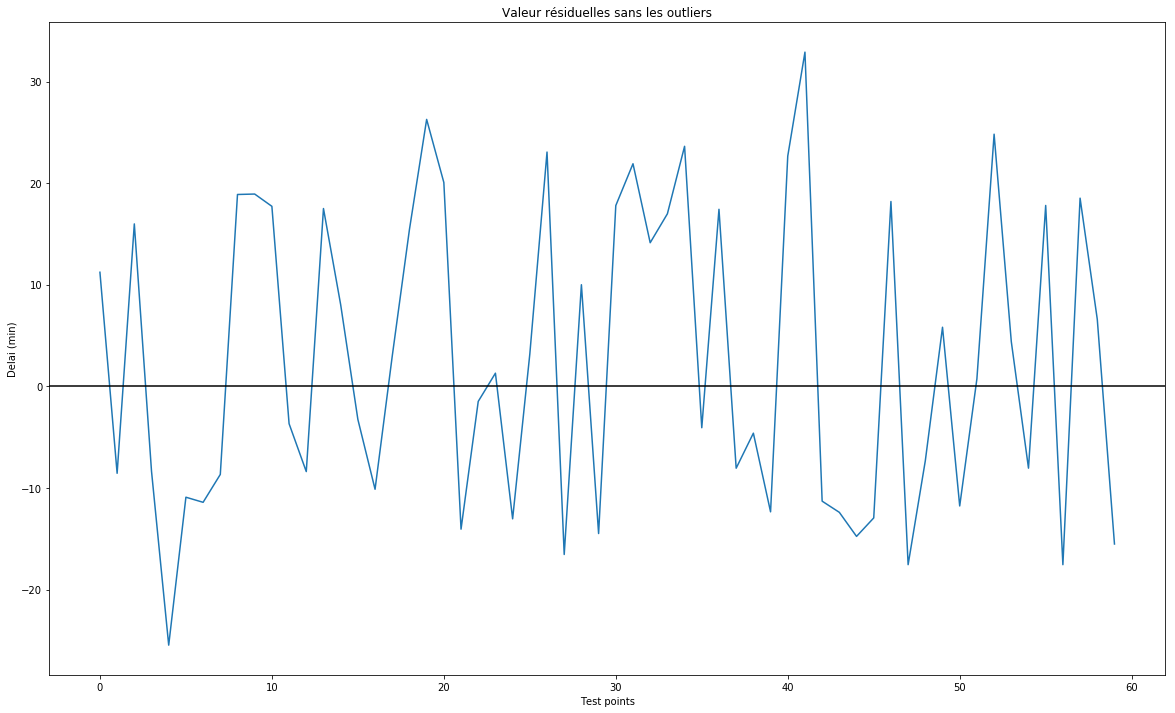

In [57]:
residual = y_test-y_pred

plt.figure(figsize=(20,12))
plt.plot(range(width), residual[start:start+width])
plt.axhline(y=0, c='black')

plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Valeur résiduelles sans les outliers")